## Домашнее задание №2

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [1]:
# pip install gensim

In [2]:
# pip install razdel

In [3]:
# pip install pymorphy2

In [4]:
# pip install nltk

In [5]:
import pandas as pd

Наши новости

In [6]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [7]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [8]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [9]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikhail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [12]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-13-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 29 s


In [15]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 5s


А теперь в 3 строчки обучим нашу модель

In [16]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [17]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [18]:
common_dictionary[10]

'ватутин'

In [19]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 3),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 3),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [20]:
from gensim.models import LdaModel

In [21]:
LdaModel?

In [22]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 39.3 s


In [23]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [24]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.27496892),
 (7, 0.12226342),
 (13, 0.07925838),
 (15, 0.34591794),
 (21, 0.08390027),
 (23, 0.076697305)]

In [25]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: мозг год спрос живой зарплата свидетель параметр
topic_1: взрыв рак китайский характерный китай обращение сибирский
topic_2: украина тело год украинский который штат земля
topic_3: nn поверхность снижение поток год час метр
topic_4: продукция британский великобритания терминал модель арбитраж уверять
topic_5: который это год журнал мочь научный банк
topic_6: станция конкурс nn квартира температура праздник градус
topic_7: это который год весь мочь страна всё
topic_8: военный год россия данные помощь находиться который
topic_9: человек который ребёнок год это время власть
topic_10: газ су таиланд метан корзина джонсон калининградский
topic_11: лекарство плата заработный святой зарплата римский итальянский
topic_12: рубль дело сотрудник полиция уголовный задержать закон
topic_13: век налог сигнал год северный германия иран
topic_14: это проект эксперт россия год развитие население
topic_15: погибнуть экипаж миссия год место фестиваль обнаружить
topic_16: область банк совет дирек

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [26]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [27]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.012310,0.0,0.000000,0.000000,0.085176,0.000000,0.0,...,0.000000,0.858451,0.0,0.014148,0.0,0.0,0.00000,0.0,0.022517,0.0
1,4896,0.0,0.122193,0.000000,0.0,0.000000,0.325565,0.455700,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0
2,4897,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.312695,0.131842,0.0,...,0.353299,0.000000,0.0,0.000000,0.0,0.0,0.08578,0.0,0.017296,0.0
3,4898,0.0,0.000000,0.302611,0.0,0.000000,0.000000,0.355635,0.110128,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.204793,0.0
4,4899,0.0,0.000000,0.000000,0.0,0.096127,0.000000,0.000000,0.000000,0.0,...,0.000000,0.878302,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [28]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [29]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [30]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.223469  ,
       0.        , 0.        , 0.        , 0.11238825, 0.        ,
       0.        , 0.        , 0.        , 0.0912761 , 0.        ,
       0.        , 0.        , 0.        , 0.07286205, 0.48785722])

In [31]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [32]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.00691097, 0.02980764, 0.        ,
       0.04196225, 0.        , 0.14111603, 0.0923901 , 0.05841788,
       0.        , 0.        , 0.08303788, 0.        , 0.0983436 ,
       0.01560477, 0.03214255, 0.05480741, 0.04617307, 0.        ,
       0.        , 0.        , 0.        , 0.00372456, 0.28556695])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [33]:
#users['articles'].iloc[33]

In [34]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [35]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.01688,0.104971,0.032839,0.00478,0.071873,0.067103,0.025452,0.030400,...,0.008178,0.016293,0.075316,0.015213,0.0,0.000000,0.005222,0.006186,0.012144,0.253555
1,u108690,0.011570,0.00000,0.108729,0.007459,0.00000,0.056275,0.020995,0.072960,0.034363,...,0.002423,0.029683,0.015458,0.019343,0.0,0.002422,0.001973,0.019695,0.023863,0.285916
2,u108339,0.005177,0.00000,0.115242,0.055545,0.00650,0.046395,0.031839,0.013928,0.128513,...,0.038332,0.023869,0.027567,0.018199,0.0,0.000000,0.000000,0.000000,0.013241,0.168014


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [36]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [37]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.01688,0.104971,0.032839,0.00478,0.071873,0.067103,0.025452,0.030400,...,0.016293,0.075316,0.015213,0.0,0.000000,0.005222,0.006186,0.012144,0.253555,0
1,u108690,0.011570,0.00000,0.108729,0.007459,0.00000,0.056275,0.020995,0.072960,0.034363,...,0.029683,0.015458,0.019343,0.0,0.002422,0.001973,0.019695,0.023863,0.285916,1
2,u108339,0.005177,0.00000,0.115242,0.055545,0.00650,0.046395,0.031839,0.013928,0.128513,...,0.023869,0.027567,0.018199,0.0,0.000000,0.000000,0.000000,0.013241,0.168014,1


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [40]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [41]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18801497, 0.07375908, 0.54024876, 0.09806346, 0.03326474,
       0.0401189 , 0.22575222, 0.01597435, 0.0417947 , 0.33286425])

In [42]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [43]:
import itertools

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.288142, F-Score=0.719, Precision=0.697, Recall=0.743


In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1676   79]
 [  64  181]]


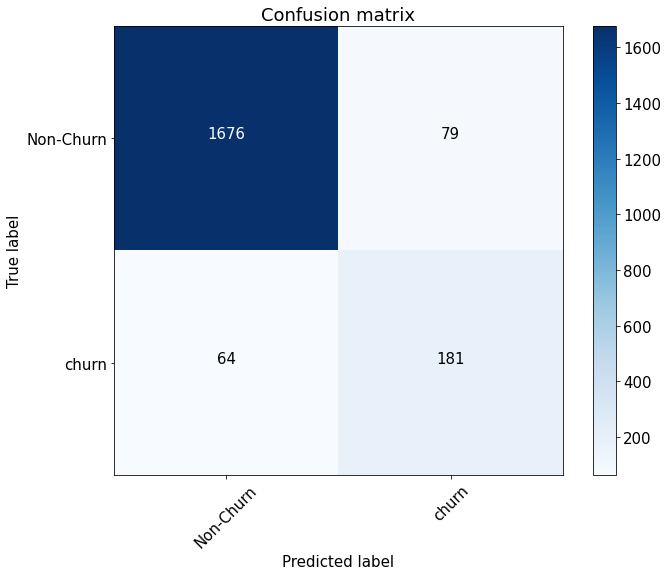

In [46]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [59]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9601023315309029

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

ДОМАШНЕЕ ЗАДАНИЕ

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [48]:
user_articles_list_median = users['articles'].iloc[33]

def get_user_embedding_median(user_articles_list_median):
    user_articles_list = eval(user_articles_list_median)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [49]:
get_user_embedding_median(user_articles_list_median)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0491437 , 0.        , 0.05347671, 0.05495176, 0.00877053,
       0.        , 0.        , 0.        , 0.        , 0.05593423,
       0.01083904, 0.        , 0.02616808, 0.01226329, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3125508 ])

In [50]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.030981,0.0,0.0,0.000000,0.038262,0.000000,0.000000,...,0.000000,0.000000,0.029548,0.000000,0.0,0.0,0.0,0.0,0.000000,0.267351
1,u108690,0.0,0.0,0.076521,0.0,0.0,0.054669,0.005730,0.068759,0.013457,...,0.000000,0.029213,0.005280,0.012495,0.0,0.0,0.0,0.0,0.012024,0.283999
2,u108339,0.0,0.0,0.102545,0.0,0.0,0.028451,0.026737,0.000000,0.143736,...,0.015482,0.009970,0.018888,0.000000,0.0,0.0,0.0,0.0,0.009317,0.168686


In [51]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.030981,0.0,0.0,0.000000,0.038262,0.000000,0.000000,...,0.000000,0.029548,0.000000,0.0,0.0,0.0,0.0,0.000000,0.267351,0
1,u108690,0.0,0.0,0.076521,0.0,0.0,0.054669,0.005730,0.068759,0.013457,...,0.029213,0.005280,0.012495,0.0,0.0,0.0,0.0,0.012024,0.283999,1
2,u108339,0.0,0.0,0.102545,0.0,0.0,0.028451,0.026737,0.000000,0.143736,...,0.009970,0.018888,0.000000,0.0,0.0,0.0,0.0,0.009317,0.168686,1


In [52]:
#разделим данные на train/test
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [53]:
logreg_median = LogisticRegression()
#обучим 
logreg_median.fit(X_median_train, y_median_train)

LogisticRegression()

In [54]:
#наши прогнозы для тестовой выборки
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_median[:10]

array([0.09992057, 0.03408721, 0.69877495, 0.09134811, 0.06322998,
       0.0522591 , 0.1390883 , 0.02019078, 0.03988603, 0.34444134])

In [55]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.317912, F-Score=0.804, Precision=0.812, Recall=0.796


Confusion matrix, without normalization
[[1710   45]
 [  51  194]]


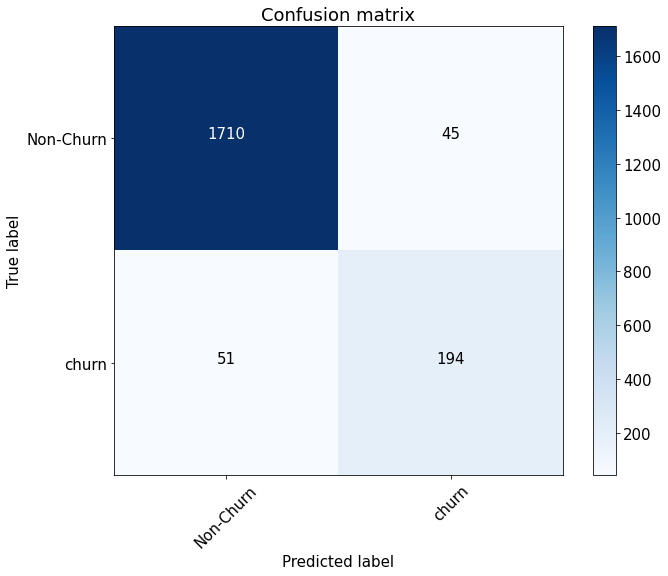

In [56]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_median_test, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc_median = roc_auc_score(y_median_test, preds_median)
roc_auc_median

0.9800895400895401

3. Повторить п.2, но используя уже не медиану, а max

In [60]:
user_articles_list_max = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list_max):
    user_articles_list = eval(user_articles_list_max)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [61]:
get_user_embedding_max(user_articles_list_max)

array([0.        , 0.        , 0.02597513, 0.17884585, 0.        ,
       0.07304955, 0.        , 0.43457487, 0.31438226, 0.20564893,
       0.        , 0.        , 0.36818361, 0.        , 0.34326929,
       0.03983341, 0.19285533, 0.21725543, 0.21599522, 0.        ,
       0.        , 0.        , 0.        , 0.02234735, 0.41351992])

In [62]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.071069,0.353112,0.197032,0.028683,0.323165,0.189725,0.089865,0.182397,...,0.049067,0.084628,0.258283,0.091276,0.0,0.00000,0.031332,0.037118,0.072862,0.487857
1,u108690,0.046247,0.000000,0.326683,0.044756,0.000000,0.089287,0.085011,0.152923,0.130642,...,0.014540,0.060848,0.055378,0.058860,0.0,0.01453,0.011841,0.099495,0.094304,0.404513
2,u108339,0.016311,0.000000,0.225607,0.300142,0.026636,0.142250,0.080884,0.070767,0.205351,...,0.119328,0.086536,0.068558,0.076916,0.0,0.00000,0.000000,0.000000,0.035023,0.393662


In [63]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.071069,0.353112,0.197032,0.028683,0.323165,0.189725,0.089865,0.182397,...,0.084628,0.258283,0.091276,0.0,0.00000,0.031332,0.037118,0.072862,0.487857,0
1,u108690,0.046247,0.000000,0.326683,0.044756,0.000000,0.089287,0.085011,0.152923,0.130642,...,0.060848,0.055378,0.058860,0.0,0.01453,0.011841,0.099495,0.094304,0.404513,1
2,u108339,0.016311,0.000000,0.225607,0.300142,0.026636,0.142250,0.080884,0.070767,0.205351,...,0.086536,0.068558,0.076916,0.0,0.00000,0.000000,0.000000,0.035023,0.393662,1


In [64]:
#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [65]:
logreg_max = LogisticRegression()
#обучим 
logreg_max.fit(X_max_train, y_max_train)

LogisticRegression()

In [66]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]
preds_max[:10]

array([3.08773841e-01, 3.09874383e-04, 8.88242382e-01, 1.07559494e-01,
       4.67119131e-03, 1.96843685e-03, 4.51700790e-02, 7.08881766e-03,
       2.67870435e-03, 3.97960201e-01])

In [67]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.322456, F-Score=0.818, Precision=0.763, Recall=0.882


Confusion matrix, without normalization
[[1688   67]
 [  30  215]]


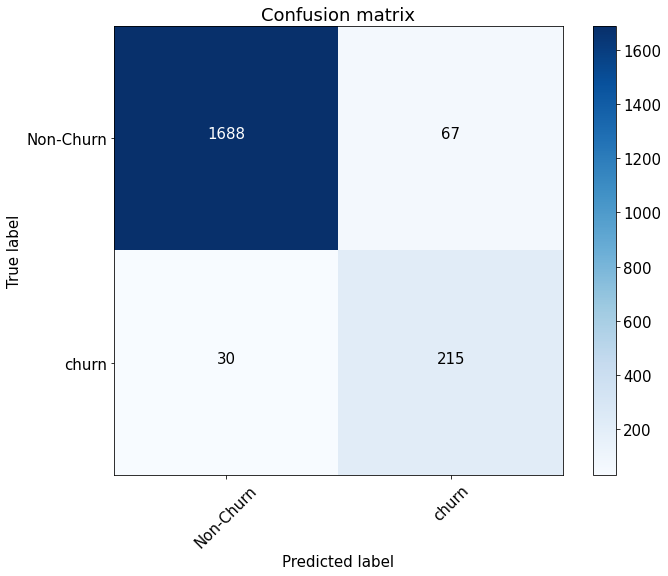

In [68]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_max_test, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [79]:
roc_auc_max = roc_auc_score(y_max_test, preds_max)
roc_auc_max 

0.9790964590964591

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [70]:
# Не сделал

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [85]:
summary_table = pd.DataFrame({'roc_auc': [roc_auc, roc_auc_median, roc_auc_max], 'precision': [precision[ix], precision_median[ix_median], precision_max[ix_max]], 'recall': [recall[ix], recall_median[ix_median], recall_max[ix_max]], 'f_score': [fscore[ix], fscore_median[ix_median], fscore_max[ix_max]]}, index = ['mean_edition', 'median_edition', 'max_edition'])
summary_table

,roc_auc,precision,recall,f_score
mean_edition,0.960102,0.697318,0.742857,0.719368
median_edition,0.980090,0.812500,0.795918,0.804124
max_edition,0.979096,0.763251,0.881633,0.818182


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Исходя из полученных значений мой выбор падает на вариант с медианой в качестве метода получения эмбендингов. Он выглядит наиболее сбалансированным по параметрам precision, recall, f_score, а также дает максимальный roc_auc